# Image recognition of Anderson states

## Preliminaries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import torch.nn
torch.__version__
from torch.utils.data import Dataset, DataLoader
#from torchvision import transforms, utils
#!pip install torch=='1.7.0'
#!pip install torchvision=='0.8.1'
import torch
import torchvision
print(torchvision.__version__)
print(torch.__version__)

0.8.1+cu101
1.7.0+cu101


In [3]:
import random
import math

In [4]:
#!pip install fastai==1.0.61
import fastai
from fastai.collab import *
#!pip install --upgrade fastai
#!pip uninstall fastai -y
print(fastai.__version__)
from fastai.vision import *


1.0.61


In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


##Functions and definition of parameters


In [6]:
def get_files(folder):
  dir = '/content/drive/MyDrive/csvdata/'+folder+'/'
  N = 1    #Desired number of input systems per class
  files = !ls -l {dir}
  print(files)
  files.reverse()
  files.pop()
  for i in range(len(files)):
    files[i] = files[i].rsplit(' ',1)[1]
    print(files[i])
  return dir,files

In [7]:
d_type_opt = ('training', 'validation')

#bs = 64
bs = 64  # uncomment this line if you run out of memory even after clicking Kernel->Restart
epoch_chunk = 15
t_f_default = 0.6
v_f_default = 0.3
training_fraction   = t_f_default
validation_fraction = v_f_default

In [8]:
def to_list(list):
  py_list = []
  for i in list:
    py_list.append(float(i))
  return py_list

## Reading in the image data

In [9]:
"""

#@title Default title text
import os

data   = []
labels = []

datasrc = '/home/epp/phupqr/PX319MLPhases/MachineLearning-Anderson/raw_system_data_refs' #Source of the locations of the data

disorder_systems      = []
disorder_class_labels = []

for disorder_class_folder in os.scandir(datasrc):                #Go through each of the disorder folders...
    print(disorder_class_folder.path)
    disorder_class = disorder_class_folder.path.rsplit('_',1)[1]
    print(disorder_class)
    disorder_systems.append([])
    disorder_class_labels.append(disorder_class)
    
    for file in os.scandir(disorder_class_folder.path):          #...find the file in each folder...
        #print(file)                                             #...
        the_file = open(file.path, 'r')                          #...open the file to read the locations of the data...
        
        number_of_data = 0
        for line in the_file:                                    #...for each... 
            
            if (number_of_data < 1):                           #...gather a certain amount of data...
                print(" ")
                number_of_data += 1

                #print(line)
                line = line.rsplit('\n',1)[0]
                raw_data = open(line,'r')
                system = make_3D_structure(raw_data, 20)
                #print(system)
                disorder_systems[-1].append(system)
                print("added system to " + disorder_class_labels[-1])
     
"""

'\n\n#@title Default title text\nimport os\n\ndata   = []\nlabels = []\n\ndatasrc = \'/home/epp/phupqr/PX319MLPhases/MachineLearning-Anderson/raw_system_data_refs\' #Source of the locations of the data\n\ndisorder_systems      = []\ndisorder_class_labels = []\n\nfor disorder_class_folder in os.scandir(datasrc):                #Go through each of the disorder folders...\n    print(disorder_class_folder.path)\n    disorder_class = disorder_class_folder.path.rsplit(\'_\',1)[1]\n    print(disorder_class)\n    disorder_systems.append([])\n    disorder_class_labels.append(disorder_class)\n    \n    for file in os.scandir(disorder_class_folder.path):          #...find the file in each folder...\n        #print(file)                                             #...\n        the_file = open(file.path, \'r\')                          #...open the file to read the locations of the data...\n        \n        number_of_data = 0\n        for line in the_file:                                    #...f

In [10]:
def make_3D_structure(file, system_size):
    col = 0
    row = 0
    lay = 0
    
    system = []
    for i in range(system_size):
        system.append([])
        for j in range(system_size):
            system[-1].append([])
            for j in range(system_size):
                system[-1][-1].append([])
    #print(len(system))
    #print(len(system[0]))
    #print(len(system[0][0]))
    
    for line in file:
        if col == system_size:
            col = 0
            row += 1
        if row == system_size:
            row = 0
            lay += 1
        system[col][row][lay] = float(line)
        #print(float(line))
        col += 1
    return system
        

##Object definitions

**Definition of our custom Dataset and label_list class for confusion matrix**

In [22]:
class label_list():
  def __init__(self, data, label_names):
    self.classes = label_names
    self.items = data
  def get(self,i):
    return self.items[i]
  def len(self):
    return len(self.classes)

class ThreeDDataset(Dataset):
    def __init__(self, x, y):
        self.x = []
        self.y = []
        class_ind = 0
        for dis_class in x:
          for item in dis_class:
            self.x.append(item)
            self.y.append(class_ind)
          class_ind+=1
        self.y = label_list(self.y, y)
        print("data: ", len(self.x))
        print("labels: ", self.y.len(), " ", self.y.items)
        self.c = len(self.y.classes)

        t = True
        for dis_class in self.x:
          t = t and len(dis_class)==0
        self.is_empty=t
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i],self.y.get(i)
        

**Definition of our custom Neural Network Model**

In [23]:
class NNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(20, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7 * 7 * 32, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out


##Training Functions


In [24]:
def load_latest_training(learn, c_model):
  dir = '/content/drive/MyDrive/ModelStages/'+c_model+'/'
  training_files = !ls -l {dir}
  training_files.reverse()
  training_files.pop()

  max_epoch_value = 0
  for i in range(len(training_files)):
    training_files[i] = training_files[i].rsplit(' ',1)[1]
    if int(training_files[i].rsplit('-',1)[1].rsplit('.',1)[0]) > max_epoch_value:
      max_epoch_value = int(training_files[i].rsplit('-',1)[1].rsplit('.',1)[0])
  learn.load(dir+'epochs-'+str(max_epoch_value))
  return max_epoch_value

#Primary code that loads data and sends it to correct object

In [27]:
import pandas as pd
import io


def prepare_datasets(folder,d_type):
  folder = folder + d_type
  if d_type=='validation':
    training_fraction  =0.1
    validation_fraction=0.99
  elif d_type=='training':
    training_fraction  =t_f_default
    validation_fraction=v_f_default


  dir = '/content/drive/MyDrive/csvdata/'+folder+'/'
  files = !ls -l {dir}
  files.reverse()
  files.pop()
  for i in range(len(files)):
    files[i] = files[i].rsplit(' ',1)[1]


  tensors_training   = []  #Each list in this list is a seperate label list
  tensors_validation = []  #
  tensors_testing    = []  #
  global n_labels
  n_labels = len(files)    #Defined by the number of data csv files
  print("Number of classes: ", n_labels)

  labels = []
  class_val = 0
  for class_file in files:
    """
    Add new class to the tensors list, read the systems one by one out 
    of the data file then add that data to the correct class list in tensors
    and add the name of the disorder class to the labels list   
    """
    tensors_training.append([])
    tensors_validation.append([])
    tensors_testing.append([])
    print(class_file)
    disorder_class = class_file.rsplit('-',1)[0]
    disorder_class = disorder_class.rsplit('W',1)[1]
    labels.append(disorder_class)

    with open(dir+class_file, 'r') as f:
      df = pd.read_csv(f)

    for i in range(len(df.transpose())-1):         
      """
      Go through each system and add them to the data
      """           
      ThreeD_array = make_3D_structure(to_list(df[str(i)]),20)
      system = torch.tensor(ThreeD_array)

      ran_numb = random.random()
      if ran_numb >= 1 - training_fraction:
        tensors_training[-1].append(system)
      
      elif ran_numb < validation_fraction:
        tensors_validation[-1].append(system)
      
      else:
        tensors_testing[-1].append(system)
    class_val+=1
  print(labels)

  loader_training = ThreeDDataset(tensors_training, labels)
  loader_validation = ThreeDDataset(tensors_validation, labels)
  loader_testing = ThreeDDataset(tensors_testing, labels)
  databunch = DataBunch.create(loader_training, loader_validation, loader_testing, bs=bs, num_workers=1)
  return databunch

#Function that creates a learner from a dataset and choice of training or validation mode

In [28]:
def create_learner(folder,d_type):
  databunch = prepare_datasets(folder, d_type)
  global learn 
  learn = cnn_learner(databunch, models.resnet18, metrics=error_rate, loss_func=torch.nn.CrossEntropyLoss(), pretrained=False)
  global c_model
  c_model = 'resnet18-'      #Model
  metric = 'metric=error_rate-'     #Metric
  loss = 'loss=CrossEntropyLoss' #Loss 
  c_model = c_model+metric+loss
  !mkdir /content/drive/MyDrive/ModelStages/{c_model}

    #Print the layer structure
  for i in range(len(learn.model)):
    #print(i, "    ", learn.model[i])
    for j in range(len(learn.model[i])):
      #print(j, "    ", learn.model[i][j])
      pass

  learn.model[0][0] = nn.Conv2d(20, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  learn.model[1][8] = nn.Linear(in_features=512, out_features=n_labels, bias=True)

  learn.save('/content/drive/MyDrive/ModelStages/'+c_model+'/epochs-0')

  if d_type=='training':
    learn.lr_find(start_lr=0.0001, end_lr=1, num_it=100, stop_div=False)
    learn.recorder.plot()
    learn.recorder.plot_lr()

#**Training Loop**

In [29]:
def train_max_epochs(epoch_goal, lr):
  n_epochs_total = 0
  learn.unfreeze()
  while n_epochs_total < epoch_goal:
    n_epochs_total = load_latest_training(learn, c_model)
    print("Best training so far: ", n_epochs_total)
    #learn.recorder.plot_losses()
    learn.fit_one_cycle(epoch_chunk,lr)
    n_epochs_total += epoch_chunk

    print('/content/drive/MyDrive/ModelStages/'+c_model+'/epochs-'+str(n_epochs_total))
    learn.save('/content/drive/MyDrive/ModelStages/'+c_model+'/epochs-'+str(n_epochs_total))

#Main Loop

In [56]:
folder = 'raw_data_transfering_100_'
d_type = d_type_opt[1]
create_learner(folder,d_type)

Number of classes:  17
W18.0-100data.csv
W17.75-100data.csv
W17.5-100data.csv
W17.25-100data.csv
W17.0-100data.csv
W16.8-100data.csv
W16.7-100data.csv
W16.6-100data.csv
W16.5-100data.csv
W16.4-100data.csv
W16.3-100data.csv
W16.2-100data.csv
W16.0-100data.csv
W15.75-100data.csv
W15.5-100data.csv
W15.25-100data.csv
W15.0-100data.csv
['18.0', '17.75', '17.5', '17.25', '17.0', '16.8', '16.7', '16.6', '16.5', '16.4', '16.3', '16.2', '16.0', '15.75', '15.5', '15.25', '15.0']
data:  186
labels:  17   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 

In [ ]:
train_max_epochs(200,0.14)

Best training so far:  15


epoch,train_loss,valid_loss,error_rate,time
0,2.837571,2.928148,0.934348,02:30
1,2.820536,2.956514,0.932826,02:38
2,2.828799,3.063221,0.910561,02:32
3,2.857069,3.167551,0.936441,02:34
4,2.869398,2.839968,0.914177,02:45
5,2.840270,2.852616,0.934539,02:37
6,2.824873,2.811313,0.917983,02:38
7,2.800418,2.848315,0.914177,02:38
8,2.779971,2.940488,0.930542,02:45
9,2.756997,2.767769,0.900476,02:50


/content/drive/MyDrive/ModelStages/resnet18-metric=error_rate-loss=CrossEntropyLoss/epochs-30
Best training so far:  30


epoch,train_loss,valid_loss,error_rate,time
0,2.635380,2.768878,0.908468,02:41
1,2.656994,2.893491,0.917793,02:38
2,2.711905,3.015774,0.932255,02:47
3,2.753263,2.856055,0.928069,02:40
4,2.778516,3.278732,0.941770,02:43
5,2.767573,3.007708,0.928639,02:41
6,2.784122,2.797158,0.908278,02:41
7,2.758751,2.798726,0.922740,02:43
8,2.750421,2.902411,0.909039,02:43
9,2.701524,2.780541,0.910181,02:45


/content/drive/MyDrive/ModelStages/resnet18-metric=error_rate-loss=CrossEntropyLoss/epochs-45
Best training so far:  45


epoch,train_loss,valid_loss,error_rate,time
0,2.477829,2.862602,0.907707,02:43
1,2.535157,2.864888,0.905233,02:47
2,2.678735,2.835944,0.909229,02:49
3,2.745816,2.831154,0.921028,02:45
4,2.752958,3.837649,0.912274,02:50
5,2.823629,2.780285,0.911323,02:53
6,2.807106,3.314886,0.905994,02:58
7,2.790648,2.796452,0.912464,02:55
8,2.766787,5.535236,0.913035,03:00
9,2.743201,2.759552,0.914177,03:00


/content/drive/MyDrive/ModelStages/resnet18-metric=error_rate-loss=CrossEntropyLoss/epochs-60
Best training so far:  60


epoch,train_loss,valid_loss,error_rate,time
0,2.597217,2.814954,0.908658,03:12
1,2.644378,2.823701,0.909610,03:12


## Interpretation

In [57]:
learn.load('/content/drive/MyDrive/ModelStages/'+c_model+'/epochs-45');
learn.load('/content/drive/MyDrive/ModelStages/'+'resnet18_error_rate_loss=CrossEntropyLoss'+'/epochs-45');

In [58]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn,preds,y,losses)

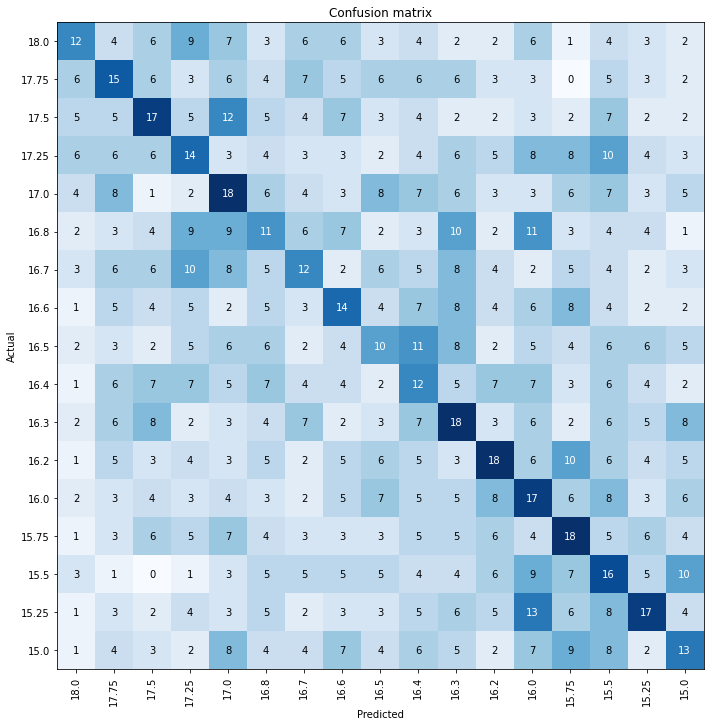

In [59]:
interp.plot_confusion_matrix(figsize=(10,10))
#print('loss = ' + str(round(1-sum(interp.confusion_matrix().diagonal())/interp.confusion_matrix().sum(),6)))

## Heatmap

In [ ]:
idx=0
x,y = loader.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [ ]:
m = learn.model.eval();

In [ ]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [ ]:
from fastai.callbacks.hooks import *

In [ ]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [ ]:
hook_a,hook_g = hooked_backward()

In [ ]:
acts  = hook_a.stored[0].cpu()
acts.shape

In [ ]:
avg_acts = acts.mean(0)
avg_acts.shape

In [ ]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,256,256,0),
              interpolation='bilinear', cmap='magma');

In [ ]:
show_heatmap(avg_acts)

In [ ]:
learn.load('/content/drive/MyDrive/ModelStages/resnet50/epochs-210');
learn.unfreeze();
#learn.lr_find()
#learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, lr)

epoch,train_loss,valid_loss,error_rate,time
0,-143.659195,-184.509506,0.279570,00:51


In [ ]:
learn.save('/content/drive/MyDrive/ModelStages/resnet50/test_run');